Building a PCA manually
Conduct a pairs-trading backtest using PCA
Simulation of multiple cointegrated assets
Sector statistical arbitrage using PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint
import matplotlib
from itertools import groupby, count
import pickle
%matplotlib inline

Unsupervised machine learning.
"Principal components" are "modes" of a system, similar to vibrational overtones of a guitar string.
They are eigenvectors of the covariance matrix.
Number of eigenvectors equals the number of features.
"Dimensionality reduction": reducing the number of eigenvectors.
Eigenvectors are "orthogonal" - uncorrelated.

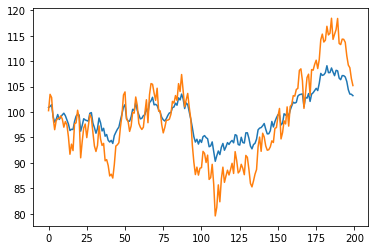

In [2]:
# two correlated time series:

# Create a random seed for consistency
np.random.seed(20)

# Produce a series as the cumulative sum of normally distributed random numbers.
x = np.cumsum(np.random.randn(200)) + 100

# Produce a second series with the same behaviour but higher standard deviation.
y = x*2 + np.random.randn(200) - 100

# Generate an array to be used in our PCA calculation.
# Note that we have to de-mean our values first.
R = np.array([x-np.mean(x),y-np.mean(y)])

# Plot x and y
plt.plot(x)
plt.plot(y)


In [3]:

# Calculate the covariance matrix
S = np.cov(R)
print('Cov Matrix:', S)

# Calculate the eigenvalues and eigenvectors
EIG = np.linalg.eig(S)
print('Eigenvalues: ',EIG[0])
print('Eigenvectors: ',EIG[1])

Cov Matrix: [[17.01547369 33.69556579]
 [33.69556579 67.62804956]]
Eigenvalues:  [ 0.18152713 84.46199612]
Eigenvectors:  [[-0.89457408 -0.4469197 ]
 [ 0.4469197  -0.89457408]]


In [4]:
# Extract the eigenvectors from EIG
EV = EIG[1]

# Create x-values for plotting eigenvectors
xx = np.linspace(min(R[0,:]),max(R[0,:]),200)

# Create y-values for plotting eigenvectors

yy1 = (EV[1][0]/EV[0][0])*xx
yy2 = (EV[1][1]/EV[0][1])*xx

In [5]:
#The most significant eigenvector is the one with the highest eigenvalue. Here we extract its row number.
most_significant_factor = np.argmax(EIG[0])
print('Most significant factor: ',most_significant_factor)

Most significant factor:  1


In [6]:
#Now we plot our de-meaned price values along with their priciple components.


In [7]:
# Correlations between factors
plt.plot(factors[0],R[0,:],'bo',label='Price 1, princomp 0')
plt.plot(factors[1],R[1,:],'ro',label='Price 2, princomp 1')
plt.plot(factors[0],R[1,:],'go',label='Price 2, princomp 0')
plt.plot(factors[1],R[0,:],'ko',label='Price 1, princomp 1')
plt.axis('equal')
plt.legend();

NameError: name 'factors' is not defined

In [ ]:
for the two-dimensional case we get exactly two principal components. With the priciple components we can now calculate our abstract factors:
# Calculating the factor values from the eigenvector
factors = np.dot(EV.T,R)

In [ ]:
# Correlations between factors
plt.plot(factors[0],R[0,:],'bo',label='Price 1, princomp 0')
plt.plot(factors[1],R[1,:],'ro',label='Price 2, princomp 1')
plt.plot(factors[0],R[1,:],'go',label='Price 2, princomp 0')
plt.plot(factors[1],R[0,:],'ko',label='Price 1, princomp 1')
plt.axis('equal')
plt.legend();
#The plot below shows how well our factors are correlated with x and y.
#Note that for each return curve we have two factors. We can see that component 1 with an eigenvalue of 84.46 has a strong correlation with x and y, component 
#0 with an eigenvalue of only 0.18 does not.

PCA Pairs Trade
The use of PCA for pairs trading and subsequent generalisation of the technique to large portfolios.
Produce pair of cointegrated price series.
Build a backtest.
Analyse the results.






First we create an algorithm for "drunk and dog" cointegration. Here,

T are the starting values
Sigma are the standard deviations of each path.
c is a variable that determines how strongly both returns are connected.
if c[0] = 0 and c[1] = 0 -> both are random walks (drunk does not own dog).
if one c is zero and the other non-zero there is a one way causality (drunk owns dog).
if both c are non-zero there is two-way causality (dog sometimes pulls drunk).

In [ ]:
def make_coint_0(N,T0=[0,0],sigma=[1,1],c=[0.1,0.1]):
    '''
    Algorithm from:
    https://www.researchgate.net/publication/254330798_A_Drunk_and_Her_Dog_An_Illustration_of_Cointegration_and_Error_Correction
    '''
    X = [0]
    Y = [0]
    for i in range(N):
        rx = np.random.randn()*sigma[0] - c[0]*(X[-1] - Y[-1])
        ry = np.random.randn()*sigma[1] + c[1]*(X[-1] - Y[-1])
        X.append(X[-1]+rx)
        Y.append(Y[-1]+ry)
    return np.array(X)+T0[0],np.array(Y)+T0[1]

In [ ]:

np.random.seed(452)
X,Y = make_coint_0(200,T0=[50,50],c=[0.1,0.1])
plt.plot(X,'r-',Y,'b-');

In [ ]:

crit = coint(X,Y)
print('Critical Values:',crit[2])
print('T-statistic:',crit[0])
print('P-value:',crit[1])

In [ ]:
Application of PCA to pairs trading:
Use the sklearn PCA package to generate components.
Linear regression with the price data.
Z-score the residual to normalise for varying price levels and volatility.
Trade when residual sufficiently deviates from mean.
Use of log prices can help to mitigate large price swings (e.g. in penny stocks)
Below the code for the PCA pairs trade:

In [ ]:
def Zscore(X):
    return np.array((X - np.mean(X)) / np.std(X))

def run_pca(pr,components=1,log_prices=True):
    
    # Instanciate PCA 
    pca = PCA(n_components=components)
    px = pr.T-np.mean(pr.T)
    
    if log_prices:
        
        # Calculate the priciple components using log prices
        comps = pca.fit(np.log(pr.T)).components_.T
        
        # Create the factors from the pricinple components
        factors = sm.add_constant(pr.T.dot(comps))
        
    else:
        
        # Calculate the N priciple components using normal prices
        comps = pca.fit(px).components_.T
        
         # Create the factors from the pricinple components
        factors = sm.add_constant(px.dot(comps))  
        

    
    # Regress each factor with the actual underlying prices
    mm = [sm.OLS(s.T, factors).fit() for s in pr]
    
    # Calculate the residuals
    resids = list(map(lambda x: x.resid, mm))
    
    return resids, factors

In [ ]:
#Running the PCA we can now see the factors with equal values of opposite sign.
Same as in "regular" pairs trade where opposite sign is expressed by long/short.
PCA gives reversible results when X and Y are switched, linear regression does not.


In [ ]:
# Create input array from cointegrated price series
R = np.array([X,Y,X])

# Run the PCA calculation
residuals, factors = run_pca(R,log_prices=True)

# Plot the residuals
plt.plot(residuals[0],label='resid X')
plt.plot(residuals[1],label='resid Y')
plt.xlabel('time')
plt.ylabel('residuals')
plt.legend()
plt.grid()

In [ ]:
As a side-node, observe that linear regression is not reversible.

Residuals are calculated as distances to fitting line along to y-axis.
In PCA residuals are calculated orthogonal to principal component.

In [ ]:

m = np.polyfit(X,Y,1)[0]
m_rev = np.polyfit(Y,X,1)[0]
print('Slope of regression:',m)
print('Inverse slope of reverse regression:',1/m_rev)


Pairs-Trade Backtest
Sequentially step through time and instruments.
Calculate if z-score of residuals is large enough to trade.
If in trade, see if residuals have mean reverted enough to exit.
Calculate the pnl.

In [ ]:
inpos = np.zeros(R.shape[0]) # side: long=+1; short=-1
pnl = [0] # PnL vector
bw = 2 # z-score threshold (bandwidth)
op = {} # dict of entry prices

# loop through time steps
for i in range(len(residuals[0])):
    p = 0 # initialise pnl-calc for a particular time step
    
    # loop through instruments
    for inst in range(R.shape[0]):
        
        # calculate the z-score of residuals
        zs = Zscore(residuals[inst])[i]
        
        # Entry condition: z-score above bandwith and no position on
        if np.abs(zs)>bw and inpos[inst] == 0:
            op[inst] = R[inst,i] # record the open price
            inpos[inst] = zs  # tell algo that we have a position
            
        # Exit condition: z-score has crossed zero and position on
        elif zs*np.sign(inpos[inst])<0:
            
            # Calculate pnl as (exit-entry)*side
            p+=((-R[inst,i]+op[inst])*np.sign(inpos[inst]))
            inpos[inst] = 0 # set side to zero
    
    # append the new pnl to vector
    pnl.append(p)
    
# Plot the results of the backtest
plt.plot(np.cumsum(pnl),'-')
plt.xlabel('time')
plt.ylabel('realised PnL')
plt.show()

Simulate sector cointegration
Simulated time series provide understandable results.
Stocks within a sector are often cointegrated.
Maths of "Drunk and her dog" generalisation shown below:
$$\begin{align}
c_{ij} = \Bigg\{ 
\begin{split}
-a_{ij} \quad for \quad i \leq j \\ 
a_{ij} \quad for \quad i \geq j \\ 
-a_{ij} \quad for \quad i = j
\end{split}
\end{align}$$$$\begin{align}
X_{t}^{(i)}-X_{t-1}^{(i)} = \sum_{j} c_{ij} X_{t-1}^{(j)} + \epsilon_{i} \quad with \quad a_{ij} \geq 0
\end{align}$$
X denotes the time series, c is the causality matrix.
a are the positive elements of the causality matrix.

In [ ]:
def make_coint_1(N,steps,a=0.1):
    X = [np.zeros(N)]
    
    # Create the causality matrix
    c = (np.tril(np.ones(N))-np.triu(np.ones(N))-np.diag(np.ones(N),0))*a #c = np.random.rand(N,N)*0.1

    # loop through time steps
    for i in range(steps):
        
        # Calculate the returns for each time series
        rx = (np.sum(c*X[-1],axis=1)+np.random.randn(N))
        
        # Add the new return to the last price of the time series
        X.append(X[-1]+rx)
        
    # return array of all series
    return np.array(X).T

In [ ]:
np.random.seed(21)
N = 3
a1 = 0.1 # general case
a2=[[0.02,0.1],[0.1,0.02]] # for N = 2
a3=[[0.06,0.04,0.08],[0.06,0.06,0.04],[0.06,0.08,0.04]] # for N = 3
X1 = make_coint_1(N,200,a=a1).T

for i in range(N):
    plt.plot(X1[:,i])

In [ ]:
print('Critical values:',coint(X1.T[0],X1.T[1])[2])
for i in range(X1.T.shape[0]):
    for k in range(i,X1.T.shape[0]):
        if not i==k:
            print('t-stats for coint of series %s and %s:'%(i,k), coint(X1.T[i],X1.T[k])[0])


PCA Portfolio Trading
Application of strategy to larger portfolio.
Careful with the causality coefficients as large numbers of strong cross-dependencies can create positive feedback loops between the series.
Larger N - higher to probability of the feedack loops for a given alpha.

In [ ]:

#np.random.seed(231)
N = 10
alpha = 0.06
X2 = make_coint_1(N,300,a=np.random.rand(N,N)*alpha) + 50

In [ ]:
for i in X2:
    plt.plot(i)


Cumulative explained variance
3 principle components explain 75% of variance
Too many components lead to very high correlation and very small PnL/trade
Enough PnL/trade to overcome trading costs

In [ ]:
pca = PCA(n_components=10)
pca.fit(np.log(X2))

# Plot cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_),'-o')
plt.grid()
plt.xlabel('Component')
plt.ylabel('Explained Variance')

In [8]:

# Cointegration test:
coints = []
print('Critical values:',coint(X2[0],X2[1])[2])
for i in range(X2.shape[0]):
    for k in range(i,X2.shape[0]):
        if not i==k:
            coints.append(coint(X2[i],X2[k])[0])
            
print('Average coint t-stats:',np.mean(coints))

NameError: name 'X2' is not defined

Sector-portfolio backtest
There are many strategies we can deploy based on our techniques such as:

sort the z-scores of our factors and go long the lowest and short the N assets with the highest z-scores.
scale the position size of each instrument according to z-score.
only rebalance portfolio when sum of z-scores exceeds a threshold.
All of them have their uses and they need to be tested on a case-by-case basis. Here, we choose the first example as shown below. This time we eliminate the forward-looking bias by recalculating the residuals at every time step.

In [9]:
mdata = pickle.load(open('marketdata.pick','rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'marketdata.pick'

In [10]:
pr = np.array(mdata).T#[:12,:]
max_pos=3
num_factors=3
initial_cash=1e6

entry = {} # create a vector of entry prices
pnls = [] # create a pnl vector

# Exit if we specified too large long/short position size
if max_pos > pr.shape[0]/2:
    print('max_pos too large!')
    adfadsf

# loop through the prices
for i,pri in enumerate(pr.T):

    # Make sure you have enough data points for PCA
    if i < 50: continue

    # Run the PCA, only on the past prices
    resids, factors = run_pca(pr.T[max([0,i-400]):i],num_factors,log_prices=False)
    zs = {}

    # Calculate the z-scores for each instrument. 
    for inst in range(len(pri)):
        try: zs[inst] = Zscore(resids[inst])[-1]
        except: pass

    pnl = 0
    # Calculate the Pnl for each position over the prevoius period
    for j,idx in enumerate(entry):

        # Calculate the position size
        # The sign of the position depends on the sign of the entry price
        pos = np.round((initial_cash/len(pri))/entry[idx])

        # Add up the pnls for all positions for the last period
        # We neutralize the sign of the entry price and let it 
        # come in through the position.
        pnl += (pri[idx]-np.abs(entry[idx]))*pos
    pnls.append(pnl)

    # Reset the portfolio
    entry = {}

    # Find the new instruments to be traded based on their z-scores
    idx_long = (np.argsort([zs[j] for j in zs])[:max_pos])
    idx_short = (np.argsort([zs[j] for j in zs])[-max_pos:])

    # Add them to the entry list
    # The entry gets a positive or negative sign depending on the side of the trade
    for idx in idx_long:
        entry[idx] = pri[idx]
    for idx in idx_short:
        entry[idx] = -pri[idx]

    print(i,sum(pnls))

NameError: name 'mdata' is not defined

In [11]:
plt.plot(np.cumsum(pickle.load(open('pnls.pick','rb'))))

FileNotFoundError: [Errno 2] No such file or directory: 'pnls.pick'